In [94]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision import models
import torchvision.transforms as transforms

import torch.utils.data as data

In [95]:
# Check GPU
divice = torch.cuda.current_device()
torch.cuda.get_device_name(divice)

'GeForce 940MX'

# Generating Data

In [154]:
# generating data by simple function
def mu_fun(x):
    y = np.pi * np.sin(x*np.pi)
    return y 

# generating training data
np.random.seed(0)
data_length = 10000

# x training
x_train = np.random.uniform(-10, 10, data_length)

# get y training
y_train = mu_fun(x_train)

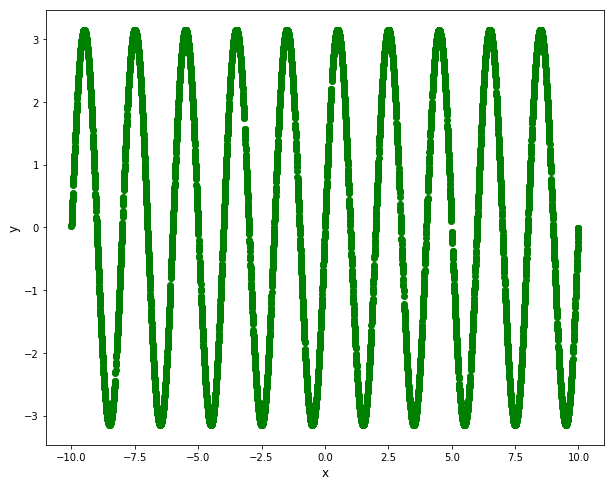

In [155]:
plt.style.use('seaborn-bright')

fig = plt.figure(figsize=(10,8))
plt.scatter(x_train, y_train,c='g')

# Label
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.show()

In [156]:
def normalize(X_train):
    '''Feature normalization with train'''
    
    mu = (sum(X_train) / X_train.shape[0]) # Calculate Mean
    sigma = np.std(X_train, axis=0) # standard deviation
    
    X_train_normed = (X_train - mu) / sigma #normalize
    return X_train_normed

X_train_normed = normalize(x_train)

# shallow Model (1 hidden layer)

In [157]:
def _shuffle(x, y):
    '''For shuffle training data'''
    randomize = np.arange(len(x))
    np.random.shuffle(randomize)
    return (x[randomize], y[randomize])


# show the model parameters
from torch.nn.modules.module import _addindent
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    total_params = 0
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
                    torch.nn.modules.container.Container,
                    torch.nn.modules.container.Sequential
                            ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        total_params += params
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    print("Total Paramesters = ", total_params)
    print("------------------------------")
    return tmpstr  

In [158]:
# Giving the model parameters
input_size = 1
hidden_size = 500
output_size = 1
learning_rate = 0.001


class ShallowNet(nn.Module):
    # NN model with one hidden layers (one input & one output)
    def __init__(self, input_size, hidden_size, output_size):
        super(ShallowNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [159]:
# Setting the model & loss function & optimizer
SNet = ShallowNet(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(SNet.parameters(), lr=learning_rate)

In [160]:
print(torch_summarize(SNet))
# paras = list(DNet.parameters())

Total Paramesters =  1501
------------------------------
ShallowNet (
  (fc1): Linear(in_features=1, out_features=500, bias=True), weights=((500, 1), (500,)), parameters=1000
  (relu): ReLU(), weights=(), parameters=0
  (fc2): Linear(in_features=500, out_features=1, bias=True), weights=((1, 500), (1,)), parameters=501
)


In [161]:
# Training model
num_epochs = 2000
batch_size = 100
step_num =  int(len(X_train_normed) / batch_size)

# Train the Model
for epoch in range(num_epochs):
    X_train_normed, y_train = _shuffle(X_train_normed, y_train)
    
    for idx in range(step_num):
        X = X_train_normed[idx*batch_size:(idx+1)*batch_size]
        Y = y_train[idx*batch_size:(idx+1)*batch_size]
        
        # Convert torch tensor to Variable and reshape to 3-th dim tensor
        X = Variable(torch.FloatTensor(X).view(batch_size,1,1))
        Y = Variable(torch.FloatTensor(Y).view(batch_size,1,1))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = SNet(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        print ('Epoch [%d/%d],  Loss: %.4f' 
                %(epoch+1, num_epochs, loss.data[0]))

Epoch [100/2000],  Loss: 4.6308
Epoch [200/2000],  Loss: 4.1048
Epoch [300/2000],  Loss: 3.0815
Epoch [400/2000],  Loss: 2.4184
Epoch [500/2000],  Loss: 1.8698
Epoch [600/2000],  Loss: 1.2941
Epoch [700/2000],  Loss: 0.8742
Epoch [800/2000],  Loss: 0.5262
Epoch [900/2000],  Loss: 0.3760
Epoch [1000/2000],  Loss: 0.2441
Epoch [1100/2000],  Loss: 0.1087
Epoch [1200/2000],  Loss: 0.0788
Epoch [1300/2000],  Loss: 0.0574
Epoch [1400/2000],  Loss: 0.0486
Epoch [1500/2000],  Loss: 0.0311
Epoch [1600/2000],  Loss: 0.0313
Epoch [1700/2000],  Loss: 0.0331
Epoch [1800/2000],  Loss: 0.0212
Epoch [1900/2000],  Loss: 0.0127
Epoch [2000/2000],  Loss: 0.0227


In [162]:
# check predict result (orig. training, no other test data)
predict = SNet(Variable(torch.FloatTensor(X_train_normed).view(len(X_train_normed),1,1)))

# Deep Model 

In [205]:
# Giving the model parameters
input_size2 = 1
output_size2 = 1
hiddens_size = [20, 20, 18, 18, 16]
learning_rate2 = 0.001


class DeepNet(nn.Module):
    # NN model with one hidden layers (one input & one output)
    def __init__(self, input_size, hiddens_size, output_size):
        super(DeepNet, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hiddens_size[0])
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hiddens_size[0], hiddens_size[1])
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hiddens_size[1], hiddens_size[2])
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hiddens_size[2], hiddens_size[3])
        self.relu = nn.ReLU()
        self.fc5 = nn.Linear(hiddens_size[3], hiddens_size[4])
        self.relu = nn.ReLU()       
        self.fc6 = nn.Linear(hiddens_size[4], output_size2)
        
        
    def forward(self, x):
        out = self.relu(self.fc1(x))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.relu(self.fc4(out))
        out = self.relu(self.fc5(out))
        out = self.fc6(out)
        return out

In [209]:
# Setting the model & loss function & optimizer
DNet = DeepNet(input_size2, hiddens_size, output_size2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(DNet.parameters(), lr=learning_rate2)

In [210]:
print(torch_summarize(DNet))
# paras = list(DNet.parameters())

Total Paramesters =  1501
------------------------------
DeepNet (
  (fc1): Linear(in_features=1, out_features=20, bias=True), weights=((20, 1), (20,)), parameters=40
  (relu): ReLU(), weights=(), parameters=0
  (fc2): Linear(in_features=20, out_features=20, bias=True), weights=((20, 20), (20,)), parameters=420
  (fc3): Linear(in_features=20, out_features=18, bias=True), weights=((18, 20), (18,)), parameters=378
  (fc4): Linear(in_features=18, out_features=18, bias=True), weights=((18, 18), (18,)), parameters=342
  (fc5): Linear(in_features=18, out_features=16, bias=True), weights=((16, 18), (16,)), parameters=304
  (fc6): Linear(in_features=16, out_features=1, bias=True), weights=((1, 16), (1,)), parameters=17
)


In [ ]:
# Training model
num_epochs = 2000
batch_size = 100
step_num =  int(len(X_train_normed) / batch_size)

# Train the Model
for epoch in range(num_epochs):
    X_train_normed, y_train = _shuffle(X_train_normed, y_train)
    
    for idx in range(step_num):
        X = X_train_normed[idx*batch_size:(idx+1)*batch_size]
        Y = y_train[idx*batch_size:(idx+1)*batch_size]
        
        # Convert torch tensor to Variable and reshape to 3-th dim tensor
        X = Variable(torch.FloatTensor(X).view(batch_size,1,1))
        Y = Variable(torch.FloatTensor(Y).view(batch_size,1,1))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        outputs = DNet(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 100 == 0:
        print ('Epoch [%d/%d],  Loss: %.4f' 
                %(epoch+1, num_epochs, loss.data[0]))

Epoch [100/2000],  Loss: 2.1366
Epoch [200/2000],  Loss: 1.7474
Epoch [300/2000],  Loss: 0.1391
Epoch [400/2000],  Loss: 0.0316
Epoch [500/2000],  Loss: 0.0493
Epoch [600/2000],  Loss: 0.0238
Epoch [700/2000],  Loss: 0.0147
Epoch [800/2000],  Loss: 0.0771
Epoch [900/2000],  Loss: 0.0066
Epoch [1000/2000],  Loss: 0.0211
Epoch [1100/2000],  Loss: 0.0143
